##### In this project I computed the value at risk of a hypothetical portfolio consisting of the top 10 stocks of Nifty50, using all the 3 methods and then back-tested the models, and finally calculated Expected Shortfall for the Portfolio.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.stats import chi2

In [2]:
tickers = ['RELIANCE.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS', 
           'ITC.NS', 'KOTAKBANK.NS', 'HINDUNILVR.NS', 'SBIN.NS', 'BHARTIARTL.NS']

In [3]:
df = yf.download(tickers, start="2024-03-31", end="2025-04-30")

In [6]:
df.head(1)

,Date,BHARTIARTL.NS,HDFCBANK.NS,HINDUNILVR.NS,ICICIBANK.NS,INFY.NS,ITC.NS,KOTAKBANK.NS,RELIANCE.NS,SBIN.NS,TCS.NS
0,01-04-2024,1210.603516,1450.690186,2246.784668,1090.26416,1457.897339,412.748627,1788.739502,1484.775024,731.112854,3809.3125


In [7]:
df.shape

(266, 11)

##### Calculating daily (log)returns for each stock

In [10]:
returns = np.log(df.select_dtypes(include='number') / df.select_dtypes(include='number').shift(1)).dropna()

##### Assigning equal weights to each stock in the portfolio

In [12]:
weights = np.array([0.10] * 10)
print(weights)
print(weights.shape)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
(10,)


##### Computing Covariance matrix

In [13]:
cov_matrix = returns.cov()
print(cov_matrix.shape)

(10, 10)


In [14]:
print(returns.mean())

BHARTIARTL.NS    0.001546
HDFCBANK.NS      0.001036
HINDUNILVR.NS    0.000124
ICICIBANK.NS     0.001023
INFY.NS          0.000101
ITC.NS           0.000119
KOTAKBANK.NS     0.000789
RELIANCE.NS     -0.000223
SBIN.NS          0.000324
TCS.NS          -0.000349
dtype: float64


##### Calculating average portfolio return

In [15]:
port_mean = weights @ returns.mean()
print(port_mean)

0.0004490268340420072


##### Calculating portfolio standard deviation

In [16]:
port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
print(port_std)

0.00859641940180329


#### Computing Parametric VaR

In [17]:
#Confidence levels
z_90 = norm.ppf(0.90)
z_95 = norm.ppf(0.95)
z_99 = norm.ppf(0.99)

In [18]:
# VaR = μ - z*σ (daily VaR)
var_90_param = port_mean - z_90*port_std
var_95_param = port_mean - z_95*port_std
var_99_param = port_mean - z_99*port_std

print(f"With 90% confidence, the daily loss will not exceed {round(-var_90_param*100,2)}% of the portfolio.")
print(f"With 95% confidence, the daily loss will not exceed {round(-var_95_param*100,2)}% of the portfolio.")
print(f"With 99% confidence, the daily loss will not exceed {round(-var_99_param*100,2)}% of the portfolio.")

With 90% confidence, the daily loss will not exceed 1.06% of the portfolio.
With 95% confidence, the daily loss will not exceed 1.37% of the portfolio.
With 99% confidence, the daily loss will not exceed 1.95% of the portfolio.


#### Computing Historical VaR

In [19]:
#Calculating portfolio returns
daily_port_return = returns@weights
print(daily_port_return)

1     -0.004312
2     -0.000353
3      0.001749
4      0.003187
5      0.003819
         ...   
261    0.004843
262   -0.008806
263   -0.002733
264    0.010461
265    0.001649
Length: 265, dtype: float64


In [20]:
#Historical VaR
var_90_hist = daily_port_return.quantile(0.10, interpolation = 'lower')
var_95_hist = daily_port_return.quantile(0.05, interpolation = 'lower')
var_99_hist = daily_port_return.quantile(0.01, interpolation = 'lower')

print(f"With 90% confidence, the daily loss will not exceed {round(-var_90_hist*100,2)}% of the portfolio.")
print(f"With 95% confidence, the daily loss will not exceed {round(-var_95_hist*100,2)}% of the portfolio.")
print(f"With 99% confidence, the daily loss will not exceed {round(-var_99_hist*100,2)}% of the portfolio.")

With 90% confidence, the daily loss will not exceed 0.87% of the portfolio.
With 95% confidence, the daily loss will not exceed 1.2% of the portfolio.
With 99% confidence, the daily loss will not exceed 2.28% of the portfolio.


In [21]:
### In the end make the below histrogran for Parametric and monte carlo and paste screenshot in github

#### Computing VaR using Monte-Carlo simulations

In [22]:
# Formula for simulating stock prices
# S_t_i = S_0_i*exp((mu_i - 0.5*sigma_i**2)*t + sigma_i*W_t) for the ith stock
# mu_i = mean return of the ith stock 
# Returns(using log) for each stock is already calculated and stored in the variable: returns. Shape is 265 rows and 10 columns
# So mu_i should be returns.mean() 
# mu = returns.mean()
# sigma_i = standard deviation of the ith stock
# sigma = returns.std()

In [23]:
#Generating uncorrelated random prices
np.random.seed(42)
simulations = 10_000
Z_uncorr = np.random.normal(0,1,size=(simulations,returns.shape[1]))
#Z_uncorr = np.random.standard_t(5,size=(simulations,returns.shape[1]))
Z_uncorr.shape

(10000, 10)

In [24]:
#Computing the Cholesky factor
L = np.linalg.cholesky(cov_matrix) #Cholesky factor
L.shape

(10, 10)

In [25]:
#Using Cholesky decomposition to generate correlated prices
Z_corr = Z_uncorr@L.T

In [26]:
#calculating daily mean returns(mu) for each stock
mu = returns.mean().values

In [27]:
#calculating daily standard deviation(sigma) for each stock
sigma = returns.std().values

In [28]:
#Initial stock prices are prices of the last day in the dataset
S_0 = df.drop(columns='Date').iloc[-1].values
S_0.shape

(10,)

In [29]:
#Simulating 10_000 prices for each stock
#S_T = S_0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
#But here I have used the covaraince matrix itself for generating correlated Z-vlaues, so not required to scale with sigma again.
T = 1 #1 day (because mu, sigma are daily)
S_T = S_0*np.exp((mu - 0.5*sigma**2)*T + np.sqrt(T)*Z_corr)
print(S_T.shape)
S_T

(10000, 10)


array([[1840.06703075, 1909.93427708, 2343.97739813, ..., 1423.8155923 ,
         804.88730324, 3501.36431558],
       [1813.77406652, 1896.65262825, 2327.10223412, ..., 1384.85704364,
         770.48514953, 3368.64088875],
       [1866.9874814 , 1913.10042811, 2331.85854677, ..., 1408.50746865,
         789.3163958 , 3465.04820037],
       ...,
       [1826.44828935, 1885.00033224, 2331.47455488, ..., 1401.65744983,
         782.5764418 , 3513.34302157],
       [1852.00609219, 1893.9339806 , 2311.6963248 , ..., 1379.00876588,
         806.22487474, 3490.23277312],
       [1844.13163467, 1934.62959974, 2317.8639829 , ..., 1416.059466  ,
         804.80729138, 3524.8571155 ]])

In [30]:
#Computing returns from the simulated prices
sim_returns = np.log(S_T/S_0)
sim_returns.shape

(10000, 10)

Note: Simulated returns are not supposed to be over time we are just simulating 10_000 different scenarios for the next day

In [31]:
#Calculating daily Portfolio returns
sim_daily_port_returns = sim_returns@weights
print(sim_daily_port_returns.shape)
print(sim_daily_port_returns)

(10000,)
[ 0.01098743 -0.01716481  0.00084878 ... -0.00378386  0.0048673
  0.00949376]


In [32]:
#Monte-Carlo VaR
var_90_mc = np.percentile(sim_daily_port_returns, 10, method = 'lower')
var_95_mc = np.percentile(sim_daily_port_returns, 5, method = 'lower')
var_99_mc = np.percentile(sim_daily_port_returns, 1, method = 'lower')

print(f"With 90% confidence, the daily loss will not exceed {round(-var_90_mc*100,2)}% of the portfolio.")
print(f"With 95% confidence, the daily loss will not exceed {round(-var_95_mc*100,2)}% of the portfolio.")
print(f"With 99% confidence, the daily loss will not exceed {round(-var_99_mc*100,2)}% of the portfolio.")

With 90% confidence, the daily loss will not exceed 1.09% of the portfolio.
With 95% confidence, the daily loss will not exceed 1.42% of the portfolio.
With 99% confidence, the daily loss will not exceed 1.98% of the portfolio.


#### Plotting the VaRs calculated using the 3 different methods

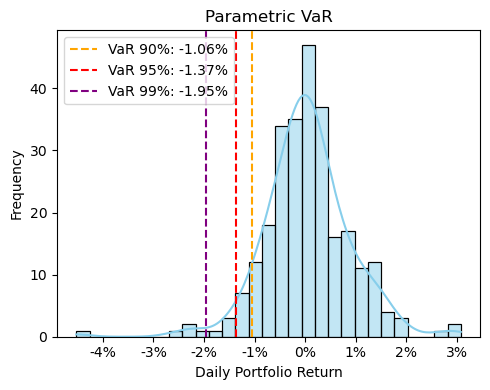

In [38]:
var_lines = {
    'VaR 90%': var_90_param * 100,
    'VaR 95%': var_95_param * 100,
    'VaR 99%': var_99_param * 100
}
colors = {
    'VaR 90%': 'orange',
    'VaR 95%': 'red',
    'VaR 99%': 'purple',
}

plt.figure(figsize=(5, 4))
plt.xlabel("Daily Portfolio Return")
plt.ylabel("Frequency")
percent_formatter = FuncFormatter(lambda x, _: f'{x:.0f}%')
sns.histplot(daily_port_return * 100, kde=True, color='skyblue')
plt.gca().xaxis.set_major_formatter(percent_formatter)

# Add vertical lines for each VaR level
for label, value in var_lines.items():
    plt.axvline(x=value, color=colors[label], linestyle='--', linewidth=1.5, label=f"{label}: {value:.2f}%")

plt.legend()
plt.title("Parametric VaR")
plt.tight_layout()
plt.show()

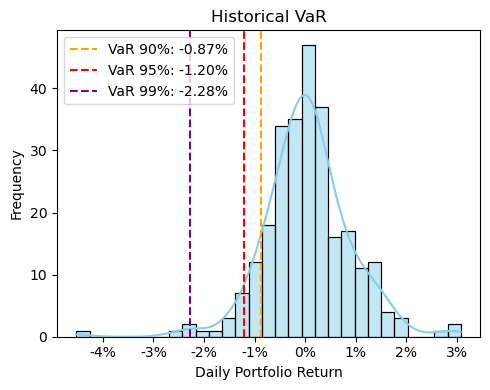

In [39]:
var_lines = {
    'VaR 90%': var_90_hist * 100,
    'VaR 95%': var_95_hist * 100,
    'VaR 99%': var_99_hist * 100
}
colors = {
    'VaR 90%': 'orange',
    'VaR 95%': 'red',
    'VaR 99%': 'purple',
}

plt.figure(figsize=(5, 4))
plt.xlabel("Daily Portfolio Return")
plt.ylabel("Frequency")
percent_formatter = FuncFormatter(lambda x, _: f'{x:.0f}%')
sns.histplot(daily_port_return * 100, kde=True, color='skyblue')
plt.gca().xaxis.set_major_formatter(percent_formatter)

# Add vertical lines for each VaR level
for label, value in var_lines.items():
    plt.axvline(x=value, color=colors[label], linestyle='--', linewidth=1.5, label=f"{label}: {value:.2f}%")

plt.legend()
plt.title("Historical VaR")
plt.tight_layout()
plt.show()

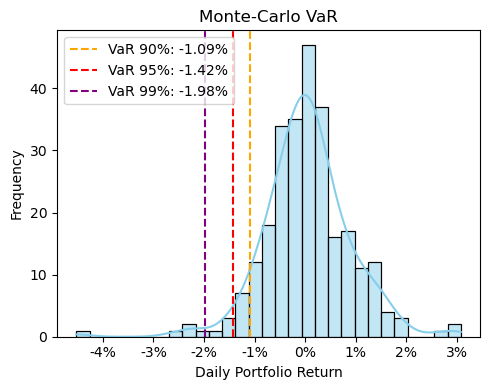

In [40]:
var_lines = {
    'VaR 90%': (var_90_mc) * 100,
    'VaR 95%': (var_95_mc) * 100,
    'VaR 99%': (var_99_mc) * 100
}
colors = {
    'VaR 90%': 'orange',
    'VaR 95%': 'red',
    'VaR 99%': 'purple',
}

plt.figure(figsize=(5, 4))
plt.xlabel("Daily Portfolio Return")
plt.ylabel("Frequency")
percent_formatter = FuncFormatter(lambda x, _: f'{x:.0f}%')
sns.histplot(daily_port_return * 100, kde=True, color='skyblue')
plt.gca().xaxis.set_major_formatter(percent_formatter)

# Add vertical lines for each VaR level
for label, value in var_lines.items():
    plt.axvline(x=value, color=colors[label], linestyle='--', linewidth=1.5, label=f"{label}: {value:.2f}%")

plt.legend()
plt.title("Monte-Carlo VaR")
plt.tight_layout()
plt.show()

### BackTesting

In [41]:
#Historical VaR at 99% has the highest absolute threshold(-2.28%), so testing only on it

#### Traffic Light Approach

In [42]:
Breaches = daily_port_return < var_99_hist

In [43]:
print(Breaches.sum())

2


Since, the number of breaches is less than 4, we are in the Green zone, and our model is good to be used.

#### Kupiec's Proportion of Failure Test

In [44]:
p = 1 - 0.99 #expected probability of breach
x = Breaches.sum() #Number of brecahes
n = len(daily_port_return) #Number of observations
p_hat = x/n #observed probability of breach

In [45]:
LR = -2*np.log(((p**x)*((1-p)**(n-x)))/((p_hat**x)*((1-p_hat)**(n-x))))

In [46]:
p_value = 1 - chi2.cdf(LR, df=1)
print(p_value)

0.6748690197554494


Since, our p-value is significantly greater than our level of significance(0.01) we fail to reject our Null Hypothesis(number of breaches is plausible under the expected rate). So our model is consistent with our expected Breach probability.

### Expected Shortfall

In [47]:
tail = daily_port_return[daily_port_return <= var_99_hist]

In [48]:
ES = tail.mean()
print(f"Expected Shortfall is approximately {round(ES*100,2)}%")

Expected Shortfall is approximately -3.14%


If losses exceed the 99% Value at Risk, the average loss in those worst 1% of days is expected to be about 3.14% of the portfolio value.

#### END OF THIS PROJECT